# Unexpectedly Short Lifetimes

## Summary of Findings

* Orbits within about +-14 degrees of the critical inclinations (63.4 and 116.6 deg) may fall into orbital resonance with the Sun and Moon which can cause a large growth in eccentricity while keeping the orbital energy fairly constant, eventually causing the satellite to impact Earth. This can occur on the timespan of a few decades. The effect actually seems to become more prominent with larger orbits, in fact more than 50% of orbits near a critical inclination starting at GEO radius decayed in less than 100 years! 

* This type of behavior was confirmed by running a few test cases with HPOP and different LifeTime settings (although some satellites would reach a local minimum in the radius of periapsis at the predicted orbital lifetime instead of actually hitting the Earth and would decay a few decades later). Perhaps this inclination could be used for a decay orbit for satellites near the critical inclination such as Molniya orbits or Tundra orbits, although there will be a concern for conjuctions as it nears reentry.

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")
import os
import pickle
import time
from functools import reduce
from comtypes.client import CreateObject
from comtypes.client import GetActiveObject
from comtypes.gen import STKObjects
from comtypes.gen import STKUtil
from comtypes.gen import AgSTKVgtLib
from IPython.display import Image
from LifeTimeLib import *

%config Completer.use_jedi = False

# Are there orbits which decay more quickly than expected?

When performing random searches over the orbital elements, there were a few orbits that had a mucher lower lifetime than originally expected. Here is an analysis of what these orbits have in common.

In [2]:
# Load tradeStudy file
tradeStudy = loadTradeStudy("LifeTimeRandomSearch")
tradeStudy.properties()

{'fileName': 'LifeTimeRandomSearch.csv',
 'numCores': 4,
 'runHPOP': False,
 'maxDur': 100,
 'decayAlt': 65,
 'epoch': 20001,
 'a': 6778,
 'e': 0,
 'i': 45,
 'AoP': 0,
 'RAAN': 0,
 'TA': 0,
 'Cd': 2.2,
 'Cr': 1.0,
 'DragArea': 13.65,
 'SunArea': 15.43,
 'Mass': 1000,
 'AtmDen': 'Jacchia 1971',
 'SolFlxFile': 'SolFlx_CSSI.dat',
 'SigLvl': 0,
 'OrbPerCal': 10,
 'GaussQuad': 2,
 'SecondOrderOblateness': 'Off',
 'howToVary': 'LatinHyperCube',
 'numberOfRuns': 100000,
 'varyCols': ['Rp',
  'Ra',
  'i',
  'AoP',
  'RAAN',
  'TA',
  'Cd',
  'Cr',
  'Drag Area',
  'Mass',
  'SolarFluxFile',
  'Density Model'],
 'varyValues': [array([ 6578, 44078]),
  array([ 6578, 44078]),
  array([  0, 180]),
  array([  0, 360]),
  array([  0, 360]),
  array([  0, 360]),
  array([1.5, 2.5]),
  array([0.5, 1.5]),
  array([1.e-01, 5.e+02]),
  array([   1, 5000]),
  array(['SolFlx_CSSI.dat'], dtype='<U15'),
  array(['Jacchia 1971'], dtype='<U12')],
 'setSunAreaEqualToDragArea': True}

For this analysis it is important to remove satellites with unrealistically high area to mass ratios.
Otherwise these satellites end up acting like extremely light weight solar sails and leading to some exhibit interesting behavior.
For reference a solar sail such as LightSail has an area of 32 m^2, a mass of 5 kg and a Cr of about 1.9, which leads a Cr A / m values of 12.
LightSail FAQs: https://www.planetary.org/explore/projects/lightsail-solar-sailing/lightsail-faqs.html

In [3]:
# Load Data Frame
dfRes = readResults(tradeStudy)

# Removes satellites with really high area to mass ratio
dfRes = dfRes[dfRes["Cr*Sun Area/Mass"] < 1]

# Summary of data
dfRes.describe()

,Run ID,epoch,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,LT Orbits,LT Years,LT Runtime
count,94931.000000,9.493100e+04,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.000000,94931.0,94931.0,94931.0,94931.000000,94931.000000,94931.000000
mean,50014.987054,1.925317e+04,25322.249188,0.262648,90.008989,180.024925,180.072906,179.913566,19083.160019,31561.338358,22917.136545,-29.980482,-35.271819,14.771135,-0.021702,-0.004041,-0.008388,2.000090,0.995833,245.582744,245.582744,2624.248767,0.299348,0.145080,10.0,2.0,0.0,954849.343207,97.378526,0.605192
std,28857.271112,2.031822e-08,7660.996663,0.186620,51.994372,103.948584,103.932263,103.904175,8841.069400,8849.542678,8452.749870,15827.645646,15839.300974,12885.765925,2.929018,2.928585,2.385044,0.288744,0.288635,144.227885,144.227885,1374.980701,0.362023,0.166473,0.0,0.0,0.0,203479.973695,13.507612,0.476510
min,0.000000,1.925317e+04,6632.104787,0.000001,0.000276,0.001754,0.000925,0.000107,6578.074014,6664.623774,6631.945337,-43556.808001,-43509.382207,-43355.576636,-9.698859,-9.878050,-9.726337,1.500001,0.500013,0.100236,0.100236,2.787062,0.000060,0.000026,10.0,2.0,0.0,14.000000,0.002464,0.006061
25%,25044.500000,1.925317e+04,19848.873038,0.102060,44.978057,90.026883,90.000239,89.980008,11601.928391,25276.078943,15819.425364,-11048.311496,-11070.600807,-7367.297099,-2.288828,-2.272714,-1.534590,1.749771,0.745412,120.069225,120.069225,1440.818846,0.092250,0.043038,10.0,2.0,0.0,999999.000000,100.000000,0.345604
50%,50043.000000,1.925317e+04,25328.888345,0.230143,89.983044,180.023517,180.125455,179.789264,17571.029832,33085.273781,22061.109564,-0.665874,16.679593,6.170187,-0.025490,-0.005094,-0.002997,2.000050,0.993713,243.546261,243.546261,2627.186660,0.186766,0.089990,10.0,2.0,0.0,999999.000000,100.000000,0.470116
75%,75006.500000,1.925317e+04,30824.213912,0.400699,135.057938,269.999906,270.082282,269.895299,25332.683050,39045.519570,29322.640131,10970.995546,11005.535010,7403.999689,2.253309,2.249793,1.503919,2.250442,1.245014,369.744801,369.744801,3813.608362,0.346872,0.173789,10.0,2.0,0.0,999999.000000,100.000000,0.694281
max,99999.000000,1.925317e+04,44062.359499,0.738845,179.999355,359.997937,359.997726,359.997763,44059.403605,44077.914205,44062.359301,43539.779899,43317.283619,43612.059035,9.857135,9.772991,10.069899,2.499995,1.499996,499.996822,499.996822,4999.981448,4.614461,0.999979,10.0,2.0,0.0,999999.000000,100.000000,25.553765


In [4]:
# Finding unexpectedly short orbit lifettimes
dfShortLifetimes = dfRes.loc[
    (dfRes["Rp"] > 10000) & (dfRes["LT Years"] < tradeStudy.maxDur)
].sort_values("LT Years")
dfShortLifetimes.describe()

,Run ID,epoch,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,LT Orbits,LT Years,LT Runtime
count,2539.000000,2.539000e+03,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.0,2539.0,2539.0,2539.000000,2539.000000,2539.000000
mean,49362.506892,1.925317e+04,34009.110591,0.200525,89.312243,179.573116,179.803417,180.086885,27830.887740,40187.333443,32136.135060,-74.704386,-181.929105,-99.406954,-0.019649,-0.004063,0.043580,1.995408,0.997476,245.602423,245.602423,2643.687982,0.297365,0.145172,10.0,2.0,0.0,32359.345018,61.397239,0.283877
std,28903.756847,1.004280e-09,5030.308729,0.156092,27.539428,103.971444,103.698912,102.969508,8573.783958,3376.570730,6890.252579,18733.048843,18740.279122,21291.827142,2.108769,2.064395,2.350656,0.287042,0.290049,142.497561,142.497561,1394.766450,0.348859,0.165424,0.0,0.0,0.0,14203.785588,21.492000,0.295705
min,21.000000,1.925317e+04,14898.733625,0.001712,49.770274,0.108551,0.140098,0.625689,10005.531726,19734.107294,13329.416453,-42725.518896,-43070.122619,-39848.601567,-6.807787,-6.855030,-7.124214,1.501369,0.500214,0.400525,0.400525,22.041169,0.000316,0.000178,10.0,2.0,0.0,7460.000000,9.112106,0.078123
25%,23821.500000,1.925317e+04,30551.055490,0.073870,63.489297,91.412753,88.479096,91.254728,21365.628164,38518.777710,27621.578264,-14990.862303,-14926.801574,-18915.310709,-1.747867,-1.550013,-2.112310,1.741892,0.741009,124.419837,124.419837,1403.890492,0.094473,0.044018,10.0,2.0,0.0,22010.500000,44.954853,0.183988
50%,49143.000000,1.925317e+04,34422.427853,0.157445,73.618395,176.215650,183.373733,180.784614,28960.448876,41071.488861,33295.283383,16.078142,10.848902,515.047392,-0.039386,-0.062232,0.108968,1.993854,0.996444,242.851248,242.851248,2650.527569,0.186699,0.091759,10.0,2.0,0.0,30363.000000,60.953141,0.234372
75%,74559.500000,1.925317e+04,37948.378612,0.299788,115.534448,270.998360,269.831969,270.659021,34833.228948,42791.012952,37592.802994,14529.490390,14420.573540,18549.798714,1.653101,1.572279,2.175497,2.237855,1.252825,370.129543,370.129543,3891.141728,0.346799,0.175879,10.0,2.0,0.0,39697.000000,79.473869,0.301489
max,99938.000000,1.925317e+04,43740.786402,0.625412,132.229490,359.874274,359.982446,359.952621,43588.614593,44077.514304,43740.257005,43041.443512,41348.705840,41245.948391,6.982198,6.590558,6.714360,2.499980,1.499702,499.665059,499.665059,4999.820368,3.122648,0.999714,10.0,2.0,0.0,145429.000000,99.993653,7.445372


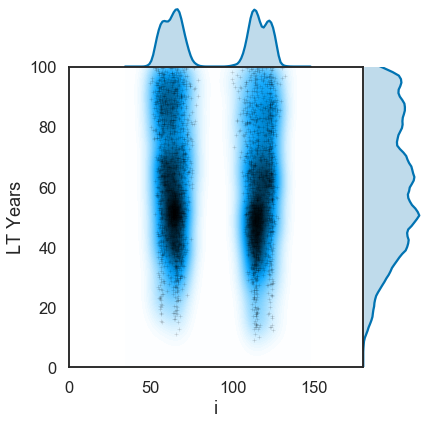

In [5]:
# i vs LT Years density distribution
data = dfShortLifetimes
ax = sns.jointplot(
    data["i"],
    data["LT Years"],
    kind="kde",
    space=0,
    n_levels=100,
    height=6,
    kernel="epa",
    bw="silverman",
    marginal_kws={"kernel": "epa", "bw": "silverman"},
)
ax.plot_joint(plt.scatter, c="k", s=20, linewidth=0.5, marker="+", alpha=0.2)
ax.ax_joint.set_xlim([0, 180])
ax.ax_joint.set_ylim([0, 100]);
# plt.plot([63.4,63.4],[0,100],'k',alpha=0.3)
# plt.plot([116.6,116.6],[0,100],'k',alpha=0.3);

Clearly there is a pattern here, all of these orbits are near the two critical inclinations which correspond to near-zero argument of perigee drift due to the Earth's J2 oblateness effects, 63.4 and 116.6.

In [6]:
# The mean inclination values for these two groups
dfGroupSum = pd.DataFrame(
    [
        dfShortLifetimes[dfShortLifetimes["i"] < 90].describe()["i"],
        dfShortLifetimes[dfShortLifetimes["i"] > 90].describe()["i"],
    ]
)
dfGroupSum.index = ["i<90", "i>90"]
dfGroupSum

,count,mean,std,min,25%,50%,75%,max
i<90,1299.0,62.987341,5.673190,49.770274,57.781329,63.726758,67.203498,78.603978
i>90,1240.0,116.889700,5.670985,99.690296,112.555884,115.667170,122.454783,132.229490


The other orbital elements such as RAAN, AoP and TA were looked at, but they did not appear to show much structure or correlation with the orbits with unexpectedly short lifetimes.

Also interestingly, the percent of the satellites that actually decay within 100 years increases with radius of periapsis altitude. Below is a plot of the percent of satellites that decay by radius of periapsis and with inclinations near the first critical inclination 63.4 deg. Similar results are found at the 116.6 inclination, but the percent that decay maxes out around 50% instead of 60%.

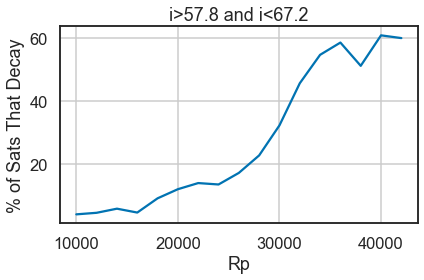

In [7]:
RPbins = np.arange(10000, 45000, 2000)
decayPercent = np.zeros(len(RPbins))
for ii in range(len(RPbins) - 1):
    satsNearCritI = (
        dfRes.loc[
            (dfRes["Rp"] > RPbins[ii])
            & (dfRes["Rp"] < RPbins[ii + 1])
            & (dfRes["i"] > dfGroupSum.loc["i<90", "25%"])
            & (dfRes["i"] < dfGroupSum.loc["i<90", "75%"])
        ]
        .describe()
        .loc["count", "Run ID"]
    )
    satsNearCritIThatDecay = (
        dfRes.loc[
            (dfRes["Rp"] > RPbins[ii])
            & (dfRes["Rp"] < RPbins[ii + 1])
            & (dfRes["i"] > dfGroupSum.loc["i<90", "25%"])
            & (dfRes["i"] < dfGroupSum.loc["i<90", "75%"])
            & (dfRes["LT Years"] < tradeStudy.maxDur)
        ]
        .describe()
        .loc["count", "Run ID"]
    )
    #     print(str(satsNearCritIThatDecay) + ' of ' + str(satsNearCritI) + ' decayed. Which is '+ '{:3.1f}'.format(satsNearCritIThatDecay/satsNearCritI*100) + ' %')
    decayPercent[ii] = satsNearCritIThatDecay / satsNearCritI * 100
ax = sns.lineplot(RPbins[:-1], decayPercent[:-1])
plt.grid(True)
plt.title(
    "i>"
    + "{:3.1f}".format(dfGroupSum.loc["i<90", "25%"])
    + " and i<"
    + "{:3.1f}".format(dfGroupSum.loc["i<90", "75%"])
)
plt.xlabel("Rp")
plt.ylabel("% of Sats That Decay")
plt.tight_layout()
plt.savefig("decayByAlt.png");

In [8]:
# Here is a small sample of some of the particularly surprising orbits.
dfRes.loc[
    dfRes["Run ID"].isin([56542, 79156, 75010, 6317, 31679, 57907, 99716])
].sort_values("LT Years")[
    ["Run ID", "a", "e", "i", "Rp", "Ra", "Cd*Drag Area/Mass", "LT Years"]
]

,Run ID,a,e,i,Rp,Ra,Cd*Drag Area/Mass,LT Years
56542,56542.0,26470.927807,0.621577,113.151733,10017.214645,42924.640969,0.386134,9.112106
57907,57907.0,32549.745221,0.345611,112.190280,21300.210189,43799.280254,0.191432,20.929546
99716,99716.0,35713.919541,0.229702,113.214791,27510.366159,43917.472923,0.076338,25.113551
75010,75010.0,37405.424103,0.166726,114.570777,31168.968970,43641.879235,0.362773,26.285024
79156,79156.0,38047.954921,0.144824,63.635511,32537.712548,43558.197295,0.348264,26.744688
6317,6317.0,40011.248151,0.083150,61.676680,36684.314316,43338.181986,0.172376,31.893002
31679,31679.0,42253.456823,0.034412,64.359277,40799.445983,43707.467664,0.192465,37.594047


In [9]:
# Load these satellites into STK to view
dfLoad = dfRes.loc[
    dfRes["Run ID"].isin([56542, 79156, 75010, 6317, 31679, 57907, 99716])
].sort_values("LT Years")
loadSats(dfLoad, maxSats=50, maxDur=tradeStudy.maxDur)

Below is Run ID 31679 propagated with HPOP, which almost hit Earth at the 37.6 year mark as the LifeTime Tool predicted, but the Solar and Lunar perturbations caused the orbit change shape once again before eventually decaying 30 years later.

![title](GEODecay.gif)